In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import pickle
import seaborn as sns
import json
from os.path import expanduser

In [3]:
experiment_name = 'P3856'
feature_detection_method = 'pasef'

IDENTIFICATIONS_DIR = '{}/identifications-pasef-cs-true-fmdw-true'.format(expanduser("~"))
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [4]:
MAXIMUM_Q_VALUE = 0.01

#### identifications with correction for saturation

In [7]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_with_cs_df = d['identifications_df']
identifications_with_cs_df = identifications_with_cs_df[(identifications_with_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

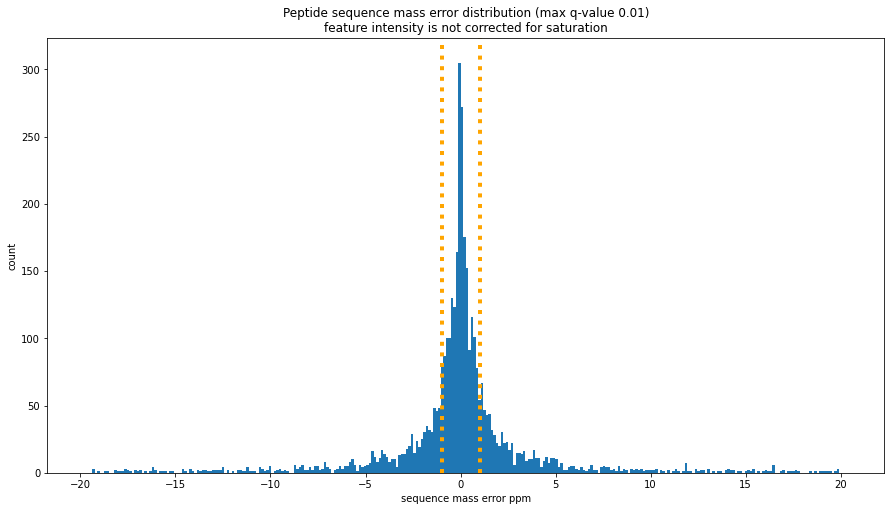

In [11]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is not corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 300
hist, bins, _ = plt.hist(identifications_with_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

# plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### identifications without correction for saturation

In [13]:
IDENTIFICATIONS_DIR = '{}/identifications-pasef-cs-false-fmdw-true'.format(expanduser("~"))
IDENTIFICATIONS_FILE = '{}/exp-{}-identifications-{}-recalibrated.pkl'.format(IDENTIFICATIONS_DIR, experiment_name, feature_detection_method)

In [14]:
# load the identifications that had saturated points in the mono
with open(IDENTIFICATIONS_FILE, 'rb') as handle:
    d = pickle.load(handle)
identifications_without_cs_df = d['identifications_df']
identifications_without_cs_df = identifications_without_cs_df[(identifications_without_cs_df['percolator q-value'] <= MAXIMUM_Q_VALUE)]

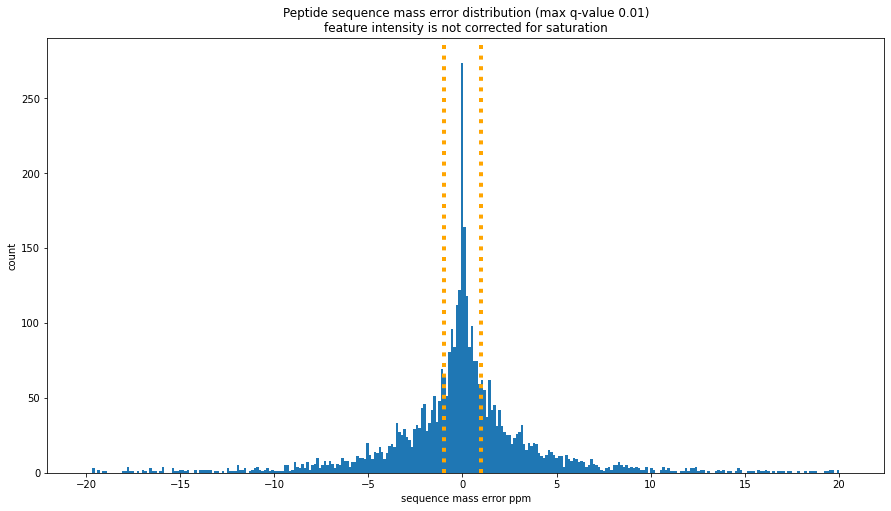

In [15]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('Peptide sequence mass error distribution (max q-value {})\nfeature intensity is not corrected for saturation'.format(MAXIMUM_Q_VALUE))

bins = 300
hist, bins, _ = plt.hist(identifications_without_cs_df.mass_accuracy_ppm, bins=bins)
plt.xlabel('sequence mass error ppm')
plt.ylabel('count')

# plt.ylim((0,1200))

plt.axvline(x=+1, linestyle=':', linewidth=4, color='orange')
plt.axvline(x=-1, linestyle=':', linewidth=4, color='orange')

plt.show()

#### dynamic range comparison

In [16]:
identifications_with_cs_df.mono_intensity_adjustment_outcome.value_counts()


monoisotopic_not_saturated         3516
monoisotopic_saturated_adjusted     240
no_nonsaturated_isotopes              5
Name: mono_intensity_adjustment_outcome, dtype: int64

In [17]:
features_l = []
for idx,row in enumerate(df.itertuples()):
    unadjusted_intensity = row.isotopic_peak_intensities_from_raw_points[0]['intensity']
    adjusted_features_l.append({'intensity':unadjusted_intensity, 'method':'unadjusted'})
    adjusted_intensity = row.isotopic_peak_intensities_from_raw_points[0]['inferred_intensity']
    adjusted_features_l.append({'intensity':adjusted_intensity, 'method':'adjusted'})
adjusted_features_df = pd.DataFrame(adjusted_features_l)
adjusted_features_df['intensity_log'] = np.log10(adjusted_features_df.intensity)

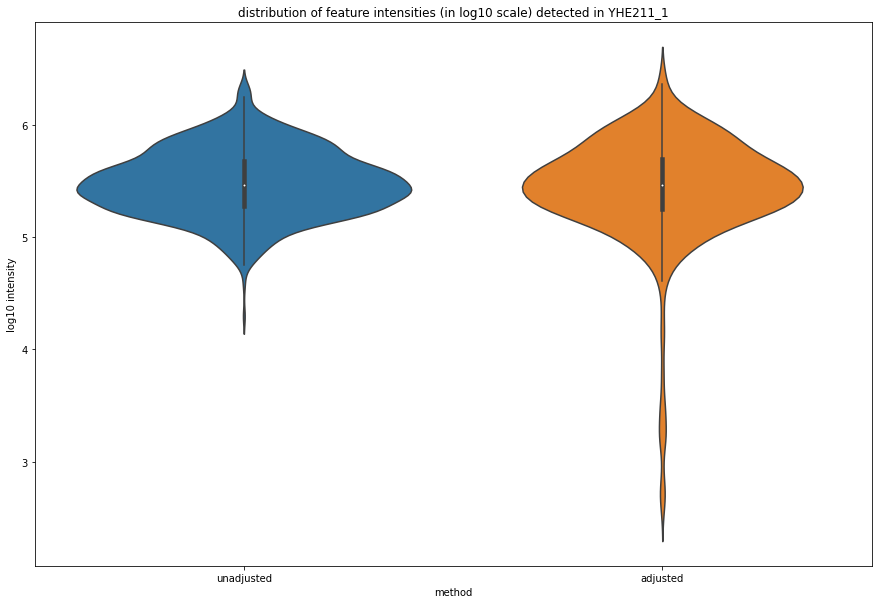

In [18]:
plt.figure(figsize=(15,10))
ax = sns.violinplot(x=adjusted_features_df.method, y=adjusted_features_df.intensity_log)
_ = plt.ylabel("log10 intensity")
_ = plt.title('distribution of feature intensities (in log10 scale) detected in YHE211_1')